# Generar Datos Basados en el template

In [17]:
import random
import numpy as np
import pandas as pd
from pathlib import Path

from faker import Faker

from openpyxl import load_workbook, Workbook

from matplotlib import pyplot as plt


In [18]:
file_path = Path.cwd() / 'Source' / 'Template' / 'IndividualProject.xlsx'
sheet_name = 'DRNG - TEST'

excel_file = pd.ExcelFile(file_path)

In [19]:
# Lectura de información
# project_information = excel_file.parse(
#     sheet_name,
#     # No tenemos headers
#     header=None,
#     # usamos las columnas P:Q
#     usecols='P:Q',
#     # saltamos las primeras 2 filas
#     skiprows=20,
#     # leemos 3 filas
#     nrows=6
# )
#
# # Limpieza de información del projecto
#
# # Completamos valor nulo
# project_information.loc[3, 15] = 'TYPE:'
# project_information.columns = ['key', 'value']
#
# # Generar obj con la información basica del projecto:
# project_inf_object = {
#     f'{record['key'].replace(':', '')}': record['value']
#
#     for idx, record in project_information.iterrows()
# }



In [20]:
fake = Faker()
project_type = lambda _: random.choice(['PUBLIC', 'PRIVATE'])




In [21]:
cities = [
    fake.city() for _ in range(10)
]

project_city = lambda _: random.choice(cities)

In [22]:
project_info_row = {
        'PROJECT ID': 0,
        'PROJECT': 21,
        'CITY': 22,
        'DATE': 23,
        'TYPE': 24,
        'PD LINK': 25,
        'BIDS RECEIVED': 26,
        'LOWEST BIDDER': 27,
    }

In [23]:
def generate_project_inf(idx: int):
    date = random.randrange(2020, 2027)

    return {
        'PROJECT ID': f'{date}{idx:03d}',
        'PROJECT': f'Project {date}{idx:03d}',
        'CITY': project_city(idx),
        'DATE': date,
        'TYPE': project_type(idx),
        'PD LINK': f'Link {idx}',
        'BIDS RECEIVED': random.randrange(5, 10)
    }

projects = [
    generate_project_inf(idx)
     for idx in range(1, 101)
]

In [24]:
df_projects = pd.DataFrame(projects)

df_projects

,PROJECT ID,PROJECT,CITY,DATE,TYPE,PD LINK,BIDS RECEIVED
0,2025001,Project 2025001,Markfort,2025,PUBLIC,Link 1,9
1,2024002,Project 2024002,Danielsbury,2024,PRIVATE,Link 2,6
2,2023003,Project 2023003,Danielsbury,2023,PRIVATE,Link 3,5
3,2023004,Project 2023004,West Melissa,2023,PRIVATE,Link 4,5
4,2023005,Project 2023005,Middletonmouth,2023,PUBLIC,Link 5,9
...,...,...,...,...,...,...,...
95,2021096,Project 2021096,Loganshire,2021,PUBLIC,Link 96,5
96,2022097,Project 2022097,Lake Brandi,2022,PUBLIC,Link 97,9
97,2024098,Project 2024098,Adamsville,2024,PRIVATE,Link 98,7
98,2025099,Project 2025099,West Melissa,2025,PUBLIC,Link 99,6


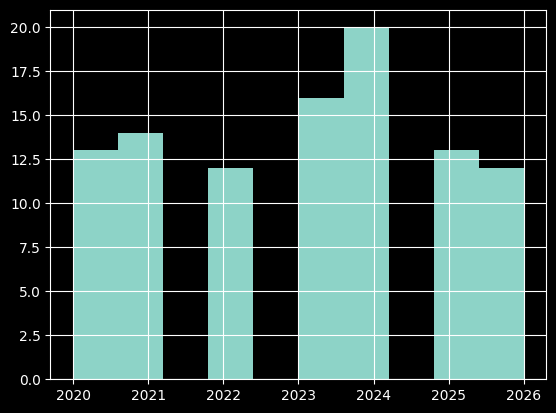

In [25]:
df_projects.DATE.hist()

In [26]:
desc_contractors_bids = excel_file.parse(
    sheet_name,
    header=1,
    skiprows=26,
    usecols='A:B',
    # nrows=2
)
desc_contractors_bids

,DESCRIPTION,UNIT
0,Mobilization,LS
1,Bonds,LS
2,Performance & Payment Bond,LS
3,Maintenance Bond,LS
4,Existing Conditions,LS
...,...,...
211,Concrete Liner for Pond Spillway,SY
212,"18"" Driveway Culvert with SET",EA
213,SWPPP Maintenance,LS
214,SWPPP Maintenance,MO


In [27]:
for idx, project in enumerate(projects):
    contractors_bids_base = desc_contractors_bids.copy(deep=True)
    for bid in range(1, project['BIDS RECEIVED'] + 1):
        contractors_bids_base[f'BID {bid}'] = None
        contractors_bids_base[f'BID {bid}'] = contractors_bids_base[f'BID {bid}'].apply(lambda x: round(random.uniform(100.1, 1000.9), 2))

        contractors_bids_base_min = contractors_bids_base.copy(deep=True)
        contractors_bids_base_min.drop(columns=['DESCRIPTION', 'UNIT'], inplace=True)
        contractors_bids_base_min = contractors_bids_base_min.sum().reset_index()
        contractors_bids_base_min = contractors_bids_base_min.loc[contractors_bids_base_min[0] == contractors_bids_base_min[0].min(), 'index']
        contractors_bids_base_min = next(iter(contractors_bids_base_min), 'N/A')
        cid = contractors_bids_base_min.split(' ')[1]

        project['LOWEST BIDDER'] = f'Contractor {cid}'


    project['BIDS'] = contractors_bids_base
    projects[idx].update(project)



In [28]:
def generate_template(project, output_path, file_name):
    wb = Workbook()
    ws = wb.active
    ws.title = sheet_name

    # Hide rows 1 through 20
    for row_num in range(1, 21):
        ws.row_dimensions[row_num].hidden = True


    bids_columns = {
        col: idx + 1 if 'BID' not in col else idx + 5
         # col: idx + 1
         # if 'DESCRIPTION' == col
         # else col: idx + 6
        for idx, col in enumerate(project['BIDS'].columns)
    }
    bids_max_col_idx = max(bids_columns.values())

    for col, value in bids_columns.items():
        # print(col, value)

        if 'BID' in col:
            cid = col.split(' ')[1]
            ws.cell(21, value, value=project['PROJECT'])
            ws.cell(26, value, value=project['PROJECT ID'])
            ws.cell(27, value, value=f"Contractor {cid}")
            ws.cell(28, value, value='BID')
        else:
            ws.cell(28, value, value=col)

    for rowIdx, row in project['BIDS'].iterrows():
        rowIdx += 1
        for col, col_idx in bids_columns.items():
            ws.cell(row = rowIdx + 28, column = col_idx, value=row.loc[col])

    # crate agg columns

    # ws.cell(28, 2, value='UNIT')
    ws.cell(28, 3, value='LOW')
    ws.cell(28, 4, value='AVERAGE')
    ws.cell(28, 5, value='COUNT')
    ws.cell(28, bids_max_col_idx + 1, value='LOW')
    ws.cell(28, bids_max_col_idx + 2, value='AVG')

    for k, v in project.items():
        if k in ['BIDS', 'PROJECT ID']:
            continue

        row = project_info_row[k]
        ws.cell(row, bids_max_col_idx + 1, value=f"{k}:")
        ws.cell(row, bids_max_col_idx + 2, value=v)

    # ws.cell(27, bids_max_col_idx + 1, value='LOWEST BIDDER:')
    output_path = output_path / file_name

    wb.save(output_path)
    wb.close()

In [29]:
output_path = Path.cwd() / 'Source' / 'DataLake'
for project in projects:

    generate_template(project, output_path, f'{project["PROJECT"]}.xlsx')